Задание
Берем отызывы за лето (из архива с материалами или предыдущего занятия)
1. Учим conv сеть для классификации
2. Рассмотреть 2-а варианта сеточек
2.1 Инициализировать tf.keras.layers.Embedding предобученными векторами взять к примеру с https://rusvectores.org/ru/
2.2 Инициализировать слой tf.keras.layers.Embedding по умолчанию (ну то есть вам ничего не делать с весами)

Сравнить две архитектуры с предобученными весами и когда tf.keras.layers.Embedding обучается сразу со всей сеточкой, что получилось лучше

In [36]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D,Flatten,\
    GlobalMaxPooling1D,Concatenate,Maximum
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping  
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score ,roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC

In [2]:
df = pd.read_excel("отзывы за лето.xls")

In [3]:
df

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14
...,...,...,...
20654,1,"Ну и шляпа,с роот правами бесполезная прога,ра...",2017-06-01
20655,5,Ок,2017-06-01
20656,4,Доволен,2017-06-01
20657,1,"Песопаснасть, рут ни нужын",2017-06-01


In [4]:
df.Rating.value_counts(normalize=True)

5    0.706036
1    0.110170
4    0.103490
3    0.044097
2    0.036207
Name: Rating, dtype: float64

In [5]:
df['target'] = df.Rating.apply(lambda x: 1 if x>3 else 0)

In [6]:
df.target.value_counts(normalize=True)

1    0.809526
0    0.190474
Name: target, dtype: float64

In [7]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def removeSpecialChars(review):
     return re.sub('[^a-zа-я]', ' ', review)
    
def preprocess_text(txt):
    txt = str(txt)
    txt = removeSpecialChars(txt.lower())
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return txt   

In [8]:
%%time
df['text'] = df['Content'].apply(preprocess_text)

Wall time: 14.8 s


In [9]:
df_train,df_test,train_y,test_y = train_test_split(df['text'],df['target'],test_size = 0.2,)

сделаем безлайн 

In [120]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df = 3000,  min_df=6)
classifier = LogisticRegression(n_jobs=16,max_iter=2000)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(df_train.apply(lambda x: ', '.join(x)), train_y)

print('acc - ',accuracy_score(model.predict(df_test.apply(lambda x: ', '.join(x))), test_y))
print('roc_auc - ',roc_auc_score(model.predict(df_test.apply(lambda x: ', '.join(x))), test_y))


acc -  0.9097289448209099
roc_auc -  0.8593337272016923


In [131]:
vectorizer = CountVectorizer(ngram_range=(1, 1),max_df = 3000,  min_df=5)
classifier = LogisticRegression(n_jobs=16,max_iter=2000)

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(df_train.apply(lambda x: ', '.join(x)), train_y)

print('acc - ',accuracy_score(model.predict(df_test.apply(lambda x: ', '.join(x))), test_y))
print('roc_auc - ',roc_auc_score(model.predict(df_test.apply(lambda x: ', '.join(x))), test_y))

acc -  0.9012584704743466
roc_auc -  0.85225347555478


In [14]:
vect= CountVectorizer(ngram_range=(1, 1),max_df = 3000,  min_df=5,binary=True)
my_words = vect.fit(df_train.apply(lambda x: ', '.join(x)))

In [15]:
word2idx = my_words.vocabulary_
len(word2idx)

1649

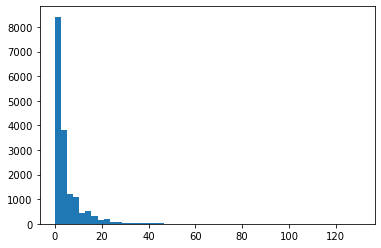

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(df_train.apply(len), bins=50)
plt.show()


In [17]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text:
            if word.lower() in word2idx:
                result.append(word2idx[word.lower()])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data
X_train = convert(df_train, word2idx, 50)
X_test = convert(df_test, word2idx, 50)


C:\Users\lqw\AppData\Local\Temp/ipykernel_4872/1248772902.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = np.zeros((len(texts), max_text_len), dtype=np.int)
C:\Users\lqw\AppData\Local\Temp/ipykernel_4872/1248772902.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check

In [66]:
metrik = AUC(name= 'auc')

In [19]:
y_train = train_y.to_numpy()
y_test = test_y.to_numpy()

In [20]:
input_x = Input(shape=(50))
x= Embedding(input_dim=len(word2idx), output_dim=128, input_shape=(X_train.shape[1],))(input_x)
x = Flatten()(x)
x = Dense(units=64,activation='relu')(x)
x = Dense(units=32,activation='relu')(x)
out_x = Dense(units=1, activation='sigmoid')(x)
model = Model(input_x,out_x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 128)           211072    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                409664    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 622,849
Trainable params: 622,849
Non-trainable params: 0
_______________________________________________________

In [252]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [253]:
model.fit(X_train, train_y, batch_size=1024, epochs=6, 
          validation_data=(X_test, test_y))
pred = model.predict(X_test)
print('acc - ',accuracy_score(test_y,(pred.flatten()>=0.5)*1    )) 
print('roc_auc_score - ',roc_auc_score(test_y,pred.flatten() ))
  

Epoch 1/6
17/17 [==============================] - 1s 13ms/step - loss: 0.4674 - accuracy: 0.8095 - val_loss: 0.3743 - val_accuracy: 0.8207
Epoch 2/6
17/17 [==============================] - 0s 7ms/step - loss: 0.3424 - accuracy: 0.8468 - val_loss: 0.2909 - val_accuracy: 0.8700
Epoch 3/6
17/17 [==============================] - 0s 7ms/step - loss: 0.2739 - accuracy: 0.8829 - val_loss: 0.2437 - val_accuracy: 0.8913
Epoch 4/6
17/17 [==============================] - 0s 7ms/step - loss: 0.2243 - accuracy: 0.9051 - val_loss: 0.2252 - val_accuracy: 0.9054
Epoch 5/6
17/17 [==============================] - 0s 7ms/step - loss: 0.2009 - accuracy: 0.9184 - val_loss: 0.2192 - val_accuracy: 0.9097
Epoch 6/6
17/17 [==============================] - 0s 7ms/step - loss: 0.1809 - accuracy: 0.9287 - val_loss: 0.2200 - val_accuracy: 0.9109
acc -  0.9109390125847048
roc_auc_score -  0.9487992320692852


Простая полнорсвязанная  сеть сразу дала лучшие результаты. Пооскольку roc_auc_score  больше , то есть ещен существенный ресурс поднять accuracy, за счет изменения точки отсечения

Рассмотрим сверточнуые сети

In [281]:
input_x = Input(shape=(50))
x= Embedding(input_dim=len(word2idx), output_dim=128, input_shape=(X_train.shape[1],))(input_x)
x = Conv1D(filters=1024,kernel_size =2, strides=1,padding='same',activation='relu')(x)
x= GlobalMaxPooling1D()(x)
x = Dense(units=64,activation = 'relu')(x)
x = Dense(units=32,activation = 'relu')(x)
out_x = Dense(units=1, activation='sigmoid')(x)
model = Model(input_x,out_x)
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_26 (Embedding)     (None, 50, 128)           213120    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 50, 1024)          263168    
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 1024)              0         
_________________________________________________________________
dense_73 (Dense)             (None, 64)                65600     
_________________________________________________________________
dense_74 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_75 (Dense)             (None, 1)                 33 

In [282]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, train_y, batch_size=1024, epochs=5, 
          validation_data=(X_test, test_y))
pred = model.predict(X_test)
print('acc - ',accuracy_score(test_y,(pred.flatten()>=0.5)*1    )) 
print('roc_auc_score - ',roc_auc_score(test_y,pred.flatten() ))

Epoch 1/5
17/17 [==============================] - 2s 70ms/step - loss: 0.5256 - accuracy: 0.7863 - val_loss: 0.3966 - val_accuracy: 0.8156
Epoch 2/5
17/17 [==============================] - 1s 59ms/step - loss: 0.3070 - accuracy: 0.8558 - val_loss: 0.2103 - val_accuracy: 0.9102
Epoch 3/5
17/17 [==============================] - 1s 59ms/step - loss: 0.2058 - accuracy: 0.9138 - val_loss: 0.2050 - val_accuracy: 0.9141
Epoch 4/5
17/17 [==============================] - 1s 59ms/step - loss: 0.1829 - accuracy: 0.9268 - val_loss: 0.2042 - val_accuracy: 0.9121
Epoch 5/5
17/17 [==============================] - 1s 59ms/step - loss: 0.1690 - accuracy: 0.9332 - val_loss: 0.2104 - val_accuracy: 0.9129
acc -  0.9128751210067764
roc_auc_score -  0.9527025553556547


свертка особьо не дает результатов  
Попробуем больше сверток

In [297]:
input_x = Input(shape=(50))
x= Embedding(input_dim=len(word2idx), output_dim=128, input_shape=(X_train.shape[1],))(input_x)

x2 = Conv1D(filters=1024,kernel_size =2, strides=1,padding='same')(x)
x2 = Dropout(0.5)(x2)
x2= Activation('relu')(x2)
x2= GlobalMaxPooling1D()(x2)


x3 = Conv1D(filters=1024,kernel_size =3, strides=1,padding='same')(x)
x3 = Dropout(0.5)(x3)
x3= Activation('relu')(x3)
x3= GlobalMaxPooling1D()(x3)


x4 = Conv1D(filters=1024,kernel_size =4, strides=1,padding='same')(x)
x4 = Dropout(0.5)(x4)
x4= Activation('relu')(x4)
x4= GlobalMaxPooling1D()(x4)


x5 = Conv1D(filters=512,kernel_size =5, strides=1,padding='same')(x)
x5 = Dropout(0.5)(x5)
x5= Activation('relu')(x5)
x5= GlobalMaxPooling1D()(x5)

x6 = Conv1D(filters=1024,kernel_size =6, strides=1,padding='same')(x)
x6 = Dropout(0.5)(x6)
x6= Activation('relu')(x6)
x6= GlobalMaxPooling1D()(x6)

y = Concatenate(axis=1)([x2, x2,x3,x4,x5,x6])

x = Dense(units=256)(y)
x = Dropout(0.3)(x)
x= Activation('relu')(x)
x = Dense(units=128)(x)
x = Dropout(0.3)(x)

x= Activation('relu')(x)
out_x = Dense(units=1, activation='sigmoid')(x)
model = Model(input_x,out_x)
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_34 (Embedding)        (None, 50, 128)      213120      input_35[0][0]                   
__________________________________________________________________________________________________
conv1d_49 (Conv1D)              (None, 50, 1024)     263168      embedding_34[0][0]               
__________________________________________________________________________________________________
conv1d_50 (Conv1D)              (None, 50, 1024)     394240      embedding_34[0][0]               
___________________________________________________________________________________________

In [298]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, train_y, batch_size=1024, epochs=3, 
          validation_data=(X_test, test_y))
pred = model.predict(X_test)
print('acc - ',accuracy_score(test_y,(pred.flatten()>=0.5)*1    )) 
print('roc_auc_score - ',roc_auc_score(test_y,pred.flatten() ))

Epoch 1/3
17/17 [==============================] - 7s 392ms/step - loss: 0.4167 - accuracy: 0.8016 - val_loss: 0.3094 - val_accuracy: 0.8734
Epoch 2/3
17/17 [==============================] - 6s 382ms/step - loss: 0.2418 - accuracy: 0.8970 - val_loss: 0.2479 - val_accuracy: 0.9066
Epoch 3/3
17/17 [==============================] - 7s 384ms/step - loss: 0.1956 - accuracy: 0.9230 - val_loss: 0.2282 - val_accuracy: 0.9097
acc -  0.9097289448209099
roc_auc_score -  0.9549052937373926


Особых изменений нет

In [30]:
y_train = to_categorical(train_y)
y_test = to_categorical(test_y)

In [26]:
input_x = Input(shape=(50))
x= Embedding(input_dim=len(word2idx), output_dim=128, input_shape=(X_train.shape[1],))(input_x)

x2 = Conv1D(filters=1024,kernel_size =2, strides=1,padding='same')(x)
x2 = Dropout(0.5)(x2)
x2= Activation('relu')(x2)
x2= GlobalMaxPooling1D()(x2)


x3 = Conv1D(filters=1024,kernel_size =3, strides=1,padding='same')(x)
x3 = Dropout(0.5)(x3)
x3= Activation('relu')(x3)
x3= GlobalMaxPooling1D()(x3)


x4 = Conv1D(filters=1024,kernel_size =4, strides=1,padding='same')(x)
x4 = Dropout(0.5)(x4)
x4= Activation('relu')(x4)
x4= GlobalMaxPooling1D()(x4)


x5 = Conv1D(filters=1024,kernel_size =5, strides=1,padding='same')(x)
x5 = Dropout(0.5)(x5)
x5= Activation('relu')(x5)
x5= GlobalMaxPooling1D()(x5)

x6 = Conv1D(filters=1024,kernel_size =6, strides=1,padding='same')(x)
x6 = Dropout(0.5)(x6)
x6= Activation('relu')(x6)
x6= GlobalMaxPooling1D()(x6)

y = Concatenate(axis=1)([x2, x2,x3,x4,x5,x6])

x = Dense(units=256)(y)
x = Dropout(0.3)(x)
x= Activation('relu')(x)
x = Dense(units=128)(x)
x = Dropout(0.3)(x)

x= Activation('relu')(x)
out_x = Dense(units=2, activation='softmax')(x)
model = Model(input_x,out_x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 128)      211072      input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 50, 1024)     263168      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 50, 1024)     394240      embedding_2[0][0]                
____________________________________________________________________________________________

In [34]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=1024, epochs=3, 
          validation_data=(X_test, y_test))
pred = model.predict(X_test)
print('acc - ',accuracy_score(y_test,(pred>=0.5)*1    )) 
print('roc_auc_score - ',roc_auc_score(y_test,pred ))

Epoch 1/3
17/17 [==============================] - 8s 434ms/step - loss: 0.1849 - accuracy: 0.9270 - val_loss: 0.2187 - val_accuracy: 0.9083
Epoch 2/3
17/17 [==============================] - 7s 426ms/step - loss: 0.1627 - accuracy: 0.9388 - val_loss: 0.2193 - val_accuracy: 0.9119
Epoch 3/3
17/17 [==============================] - 7s 426ms/step - loss: 0.1538 - accuracy: 0.9423 - val_loss: 0.2271 - val_accuracy: 0.9071
acc -  0.9070667957405615
roc_auc_score -  0.9455933942206137


In [112]:
input_x = Input(shape=(50))
x= Embedding(input_dim=len(word2idx), output_dim=128, input_shape=(X_train.shape[1],))(input_x)

x2 = Conv1D(filters=512,kernel_size =2, strides=1,padding='same')(x)
# x2 = Dropout(0.5)(x2)
x2= Activation('relu')(x2)
x2= GlobalMaxPooling1D()(x2)

x2 = Dense(units=64)(x2)
# x2 = Dropout(0.3)(x2)
x2= Activation('relu')(x2)
x2 = Dense(units=32)(x2)
# x2 = Dropout(0.3)(x2)
out_x2 = Dense(units=2, activation='softmax',name = 'out2')(x2)
model_2 = Model(input_x,out_x2)



x3 = Conv1D(filters=512,kernel_size =3, strides=1,padding='same')(x)
# x3 = Dropout(0.5)(x3)
x3= Activation('relu')(x3)
x3= GlobalMaxPooling1D()(x3)

x3 = Dense(units=64)(x3)
# x3 = Dropout(0.3)(x3)
x3= Activation('relu')(x3)
x3 = Dense(units=32)(x3)
# x3 = Dropout(0.3)(x3)
out_x3 = Dense(units=2, activation='softmax',name = 'out3')(x3)
model_3 = Model(input_x,out_x3)


x4 = Conv1D(filters=512,kernel_size =4, strides=1,padding='same')(x)
# x4 = Dropout(0.5)(x4)
x4= Activation('relu')(x4)
x4= GlobalMaxPooling1D()(x4)

x4 = Dense(units=64)(x4)
# x4 = Dropout(0.3)(x4)
x4= Activation('relu')(x4)
x4 = Dense(units=32)(x4)
# x4 = Dropout(0.3)(x4)
out_x4 = Dense(units=2, activation='softmax',name = 'out4')(x4)
model_4 = Model(input_x,out_x4)


x5 = Conv1D(filters=512,kernel_size =5, strides=1,padding='same')(x)
# x5 = Dropout(0.5)(x5)
x5= Activation('relu')(x5)
x5= GlobalMaxPooling1D()(x5)

x5 = Dense(units=4)(x5)
# x5 = Dropout(0.3)(x5)
x5= Activation('relu')(x5)
x5 = Dense(units=32)(x5)
# x5 = Dropout(0.3)(x5)
out_x5 = Dense(units=2, activation='softmax',name = 'out5')(x5)
model_5 = Model(input_x,out_x5)



x6 = Conv1D(filters=512,kernel_size =6, strides=1,padding='same')(x)
# x6 = Dropout(0.5)(x6)
x6= Activation('relu')(x6)
x6= GlobalMaxPooling1D()(x6)

x6 = Dense(units=64)(x6)
# x6 = Dropout(0.3)(x6)
x6= Activation('relu')(x6)
x6 = Dense(units=32)(x6)
# x6 = Dropout(0.3)(x6)
out_x6 = Dense(units=2, activation='softmax',name = 'out6')(x6)
model_6 = Model(input_x,out_x6)





In [113]:
out_all = Maximum()([model_2.output, model_3.output ,model_4.output,model_5.output,model_6.output])
model_ansabl = Model(input_x,out_all,name = 'ansbl')

model_ansabl.compile(loss='binary_crossentropy',
                     optimizer='adam',
                    metrics=['accuracy'])

In [114]:
model_ansabl.summary()

Model: "ansbl"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 50, 128)      211072      input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_75 (Conv1D)              (None, 50, 512)      131584      embedding_16[0][0]               
__________________________________________________________________________________________________
conv1d_76 (Conv1D)              (None, 50, 512)      197120      embedding_16[0][0]               
______________________________________________________________________________________________

In [115]:

model_ansabl.fit(X_train, y_train, batch_size=1024, epochs=7, 
          validation_data=(X_test, y_test))
pred = model_ansabl.predict(X_test)
print('acc - ',accuracy_score(y_test,(pred>=0.5)*1    )) 
print('roc_auc_score - ',roc_auc_score(y_test,pred ))

Epoch 1/7
17/17 [==============================] - 4s 193ms/step - loss: 0.4911 - accuracy: 0.7759 - val_loss: 0.3808 - val_accuracy: 0.8120
Epoch 2/7
17/17 [==============================] - 3s 182ms/step - loss: 0.3189 - accuracy: 0.8677 - val_loss: 0.2649 - val_accuracy: 0.9034
Epoch 3/7
17/17 [==============================] - 3s 182ms/step - loss: 0.2337 - accuracy: 0.9146 - val_loss: 0.2252 - val_accuracy: 0.9076
Epoch 4/7
17/17 [==============================] - 3s 182ms/step - loss: 0.1935 - accuracy: 0.9263 - val_loss: 0.2133 - val_accuracy: 0.9097
Epoch 5/7
17/17 [==============================] - 3s 182ms/step - loss: 0.1733 - accuracy: 0.9355 - val_loss: 0.2177 - val_accuracy: 0.9148
Epoch 6/7
17/17 [==============================] - 3s 182ms/step - loss: 0.1607 - accuracy: 0.9428 - val_loss: 0.2214 - val_accuracy: 0.9129
Epoch 7/7
17/17 [==============================] - 3s 182ms/step - loss: 0.1515 - accuracy: 0.9481 - val_loss: 0.2302 - val_accuracy: 0.9129
acc -  0.8983

Инициализировать tf.keras.layers.Embedding предобученными векторами  
Что это такое, как это делать, представления не имею. На уроке слово не було сказано. Что это за вектора где их взять и ка кприкрутить не потнимаю. ПРошу показать как этим пользоваться